

## Variance stablizing transform##

To have an unbiased estimate of fraction of variance explained we will stabilize the variance to simplify calculations.

I will assume that the variance to mean relationship is:

$$\sigma^2(\mu) = a\mu^b$$

Thus to stabilize the variance approximately to 1 we apply this transformation to our data:

$$f(x) = (\sqrt{a}(1-\frac{1}{2}b))^{-1}x^{1-\frac{1}{2}b}$$

Below we will focus on the case where $b=1$ and $a$ is unknown. In this case we take the square root of the data then scale it appropriately to get a variance of one. We will also see how the transformation works for other cases to see if it breaks down when when $b \neq 1$

We will estimate $a$ via:

$\hat{a} = \sum_i^n{\frac{s^2_i}{\bar{x}_i}}$

Assuming the transformation is well estimated, our sample mean neural response distribution has become a spherical guassian with a known variance $1$ but unknown mean $f({\lambda_i})$.  Our model $x_i$,  becomes, $f(x_i)$ but for simplicity lets call it $\vec{x}$ mean centered and normalized unit length and call $Y_i$ as $\vec{Y}$.

So now with the square root transformation what is the distribution of $R^2 = Cor(\vec{Y}, \vec{x})^2$?

Set up:

We have $m$ stimuli and $n$ trials:

$\vec{Y} \sim \frac{1}{n} \sum^n{N(\mu, a\mu^b)}$

We transform each set of trials so we have
$$\vec{Y}  \sim \frac{1}{n} \sum^n{N(f(\mu), 1)}$$

Now lets make sure the transform works first we will use a negative binomial to simulate response data with a variety of mean variance relationships.

n and p needed for given mu and sigma^2: [(mu**2/(-mu + s), mu/s)]


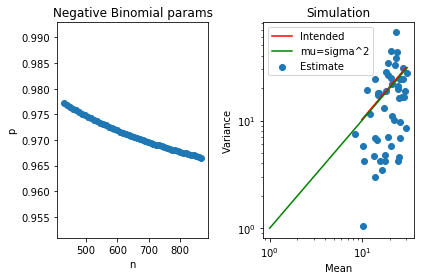

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import seaborn
from sympy import *

n = Symbol('n')
p = Symbol('p')
mu = Symbol('mu')
s = Symbol('s')
sol =solve([Eq((n*(1-p))/p-mu), Eq((n*(1-p))/(p**2)-s)],[n,p])
print('n and p needed for given mu and sigma^2: ' + str(sol))

mu = np.linspace(10,30)
s = 1*mu**1.01#set the mean variance relation

plt.subplot(121)
plt.title('Negative Binomial params')
n = mu**2./(s-mu)
p = mu/s
plt.scatter(n,p);plt.xlabel('n');plt.ylabel('p')

plt.subplot(122)
trials = 5
y = np.random.negative_binomial(n,p, size=(trials, len(n)))
s_hat = np.var(y,0)
mu_hat = np.mean(y,0)
plt.scatter(mu_hat, s_hat)
plt.plot(mu, s, c='r')

plt.plot([1,max(s)], [1,max(s)],c='g')
plt.ylabel('Variance');plt.xlabel('Mean');plt.legend(['Intended', 'mu=sigma^2', 'Estimate'])
plt.title('Simulation')
plt.loglog()
plt.tight_layout();


It seems to work pretty well but for quadratics n starts to get very small and then n gets rounded when I use negative binomial, to improve this I will need to use a different paramterization of the negative binomial which does not rely on integers. I also would like to implement a mean variance ratio that can go below one.

Okay so now the problem of estimating R^2 comes down to estimating the relationship between the mean and the variance, then using that estimate to transform the variables to have variance of 1. We will try:


- Assuming a Poisson distributed relationship.

- Estimating a linear VMR using the average variance to mean ratio.

- Estimating an exponential VMR by fitting a linear model for log transformed estimates of mean and variance.

- Using non-parametric regression to estimate the VMR:
    - In log
    - In linear




In [3]:
#our simulator
def log_lin_vpred(y):
    y_bar = y.mean(0)
    y_var = y.var(0, ddof=1)
    
    ml = np.log10(y_bar)
    vl = np.log10(y_var)
    intercept= np.ones(len(ml))
    A = np.vstack([ml, intercept]).T
    b_est, c = np.linalg.lstsq(A, vl)[0]
    b = b_est
    a = 10.**c
    
    return (a, b)

def filter_out_0(y):
    #assume n trials by m stim
    mu = np.mean(y,0)
    var = np.var(y,0, ddof=1)
    ind = (mu>0)*(var>0)
    #ind = (mu>=0)
    return y[:, ind], ind
    
def bin_vmr(mu, s2, trials=5, sims=1000):
    n = mu**2./(s2-mu)
    p = mu/s2
    y = np.random.negative_binomial(n,p, size=(sims, trials, len(n)))
    return y


def transform_exp(x, a, b):
    y = ((np.sqrt(a)*(1-0.5*b))**-1)*x**((1-0.5*b))
    return y


def vmr(y):
    y_var = np.var(y,0, ddof=1)
    y_bar = np.mean(y,0)
    
    rat = ((y_var)/(y_bar)).mean()
    return rat

def r2_unbiased(y, x):
    (n, m) = np.shape(y)
    y = y.mean(0)
    y -= y.mean()
    x -= x.mean()
    b = np.dot(y, x)/np.dot(x, x)
    y_hat = b*x#our best fit of x to y in the 1-d model space
    res = y-b*x#the left over residual in (m-2)-d null space
    num = np.sum(y_hat**2)
    den = np.sum(y_hat**2) + np.sum(res**2)
    
    R2 = (num)/(den)    
    #R2_corrected = (num - (1./n))/((den - (m-2)*(1./n) - (1./n)))
    R2_corrected = (num - (1./n))/((den - (m-1)*(1./n)))
    return R2_corrected, R2

In [4]:
n = 5 #trials
m = 362 #stimuli
n_exps = 1000 #number simulations
amplitude = 8.
base_line = 20
true_r2 = 0.2
angle = np.arccos(true_r2**0.5)

#create the expected responses
mu = base_line + (np.cos(np.linspace(0, 2*np.pi, m))*amplitude) #s
#our model is not perfect, thus its angle is some angle off
model = base_line+(np.cos(angle + np.linspace(0, 2*np.pi, m))*amplitude) #s


ab = [[1.001, 1.001], [2.1,1.001],[4.1, 1.001], [1.1, 1.9], [2.1, 1.51], [2.1, 1.9],]
s2 = [ a*mu**b for (a,b) in ab]

ys = [bin_vmr(mu, a_s2, trials=n, sims=n_exps) for a_s2 in s2]
trans_names = ['none', 'm=var','vmr known', 'vmr a_est', 'vmr ab_est']
transforms = np.zeros((len(trans_names), len(s2), n_exps, n, m))
models = np.zeros((len(trans_names), len(s2), n_exps, m))
models[...] = np.nan
transforms[...] = np.nan


for i, y, a_ab in zip(range(len(ys)), ys, ab):
    (a,b)= a_ab
    for exp in range(n_exps):
        y_exp, ind = filter_out_0(y[exp])
        transforms[0, i, exp, :, ind] = y_exp.T
        transforms[1, i, exp, :, ind] = transform_exp(y_exp, a=1., b=1.).T#assume poisson
        transforms[2, i, exp, :, ind] = transform_exp(y_exp, a=a, b=b).T#known a_b
        transforms[3, i, exp, :, ind] = transform_exp(y_exp, a=vmr(y_exp), b=1.).T
        (a_est,b_est) = log_lin_vpred(y_exp)
        transforms[4, i, exp, :, ind] = transform_exp(y_exp, a=a_est, b=b_est).T
        
        models[0,i,exp,ind] = model[ind]
        models[1, i, exp, ind] = transform_exp(model[ind], a=1., b=1.).T
        models[2, i, exp, ind] = transform_exp(model[ind], a=a, b=b).T
        models[3, i, exp, ind] = transform_exp(model[ind], a=vmr(y_exp), b=1.).T
        models[4, i, exp, ind] = transform_exp(model[ind], a=a_est, b=b_est).T

r_ests = np.zeros((len(trans_names), len(s2), n_exps))
r_ests[...] = np.nan
for i in range(transforms.shape[0]):
    for j in range(len(s2)):
        for k in range(n_exps):
            y = transforms[i,j,k]
            y, ind = filter_out_0(y)
            r_ests[i,j,k] = r2_unbiased(y, models[i, j, k, ind])[0]
            #r_ests[i,j,k] = r2_unbiased(y, model[ind])[0]

/home/dean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in power
/home/dean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in greater
/home/dean/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/dean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: Mean of empty slice.
/home/dean/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: Mean of empty slice.
/home/dean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in double_scalars
/home/dean/anaconda2/lib/python2.7/site-packages/i

In [6]:
import pandas as pd
mean_r = np.mean(r_ests,-1)
index = [str(np.round(an,2)) for an in ab]
print(pd.DataFrame(mean_r.T, columns=trans_names, index=index))
mean_r = np.std(r_ests,-1)
print(pd.DataFrame(mean_r.T, columns=trans_names, index=index))



                   none     m=var  vmr known  vmr a_est  vmr ab_est
[ 1.  1.]      0.180155  0.198120   0.198206   0.198221    0.192931
[ 2.1  1. ]    0.161141  0.176052   0.198407   0.197845    0.186476
[ 4.1  1. ]    0.133525  0.145937   0.196524   0.193579    0.171745
[ 1.1  1.9]    0.066090  0.069494   0.021796   0.180144   -0.074349
[ 2.1   1.51]  0.090643  0.100048   0.155865   0.186175    0.097271
[ 2.1  1.9]    0.041139  0.042234   0.013636   0.177083   -0.085820
                   none     m=var  vmr known  vmr a_est  vmr ab_est
[ 1.  1.]      0.013772  0.015049   0.015056   0.015070    0.014695
[ 2.1  1. ]    0.017539  0.018813   0.021257   0.021247    0.020055
[ 4.1  1. ]    0.020453  0.021602   0.029227   0.028935    0.025667
[ 1.1  1.9]    0.021290  0.022369   0.015305   0.064685    0.302208
[ 2.1   1.51]  0.021818  0.023026   0.038529   0.045814    0.032598
[ 2.1  1.9]    0.017543  0.018232   0.011342   0.470430    0.299817


(371, 22096)
(109, 371, 25, 851)


In [75]:
def r2_unbiased(y, x, n, m):
    y -= y.mean()
    x -= x.mean()
    b = np.dot(y, x)/np.dot(x, x)
    y_hat = b*x#our best fit of x to y in the 1-d model space
    res = y-b*x#the left over residual in (m-2)-d null space
    num = np.sum(y_hat**2)
    den = np.sum(y_hat**2) + np.sum(res**2)
    
    R2 = (num)/(den)    
    R2_corrected = (num - (1./n))/((den - (m-2)*(1./n) - (1./n)))
    R2_corrected = (num - (1./n))/((den - (m-1)*(1./n)))
    return R2_corrected, R2

def resamp_rows(y):
    new_y = np.zeros(np.shape(y))
    cols = new_y.shape[1]
    for i, a_row in enumerate(y):
        rcols = np.random.choice(cols, cols)
        new_y[i,:] = y[i,rcols]
    return new_y

v4 = xr.open_dataset('/loc6tb/data/responses/v4cnn/apc370t.nc')['resp']
v4.coords['unit'] = range(109)
from scipy import stats
import numpy as np

fn = 'bvlc_reference_caffenetpix_width[ 8.4096606]_x_(64, 164, 51)_y_(114.0, 114.0, 1)PC370'

da = xr.open_dataset('/loc6tb/data/responses/v4cnn/' + fn + '.nc')['resp']
da = da.sel(unit=slice(0, None, 1)).squeeze()
middle = np.round(len(da.coords['x'])/2.).astype(int)
da_0 = da.sel(x=da.coords['x'][middle])    
net = da_0 
print(net.shape)
print(v4.shape)
perms = 1
ncells= 109
rs = np.zeros((ncells, perms,  2))
rs[...] = np.nan
abss = []
vmrs=[]
true_rs = []


da_0 = da_0 - da_0.mean('shapes')
da_0n = da_0/(da_0.dot(da_0, 'shapes')**0.5)
fn = '/loc6tb/data/models/apc_models_362.nc'
apc = xr.open_dataset(fn)['resp']
apc['models'] = range(apc.shape[1])
#da_0 = apc
da_0 = da_0[apc.coords['shapes'].values]
da_0 = da_0 - da_0.mean('shapes')
da_0n = da_0/(da_0.dot(da_0, 'shapes')**0.5)
v4s = v4[:,apc.coords['shapes'].values]

(371, 22096)
(109, 371, 25, 851)


/home/dean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


51

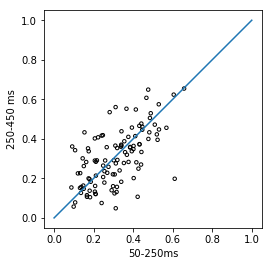

In [76]:
time_r = np.zeros((2, ncells))

for i, times in enumerate([[200,400],[400,800]]):
    for j, u in enumerate(v4s[:ncells]):
        y = u.values
        y = np.sum(y[...,times[0]:times[1]],-1)
        var = np.nanvar(y,-1)
        mu = np.nanmean(y,-1)
        n = np.sum(~np.isnan(y),-1).mean()
        vmr = np.nanmean(var/mu)

        y_expt = transform_exp(mu, a=vmr, b=1).T


        y_exptn = y_expt - np.mean(y_expt)
        y_exptn = y_exptn/(np.sum(y_exptn**2)**0.5)

        rind = np.nanargmax(np.dot(da_0[ind].values.T, y_exptn))
        true_rs.append(r2_unbiased(y_expt, da_0n[ind, rind].values, n=n, m=len(y_expt)))
        time_r[i,j] = true_rs[-1][0]
        
plt.scatter(time_r[0]**0.5, time_r[1]**0.5, s=12, edgecolors='k', facecolors='none');
plt.xlabel('50-250ms');plt.ylabel('250-450 ms')
#plt.xlim(0,1);plt.ylim(0,1);
plt.plot([0,1],[0,1])
plt.axis('square')
np.sum(time_r[0]<time_r[1])

In [9]:
v4s = v4[:,apc.coords['shapes'].values]

for i, u in enumerate(v4s[:ncells]):
    y = u.values
    y = np.sum(y[...,200:700],-1)
    var = np.nanvar(y,-1)
    mu = np.nanmean(y,-1)
    n = np.sum(~np.isnan(y),-1).mean()
    vmr = np.nanmean(var/mu)
    vmrs.append(vmr)
    #if (yshape[0]>5) and (yshape[1]>2):

    y_expt = transform_exp(mu, a=vmr, b=1).T


    y_exptn = y_expt - np.mean(y_expt)
    y_exptn = y_exptn/(np.sum(y_exptn**2)**0.5)

    rind = np.nanargmax(np.dot(da_0n.values.T, y_exptn))
    true_rs.append(r2_unbiased(y_expt, da_0n[:, rind].values, n, len(y_expt)))

/home/dean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


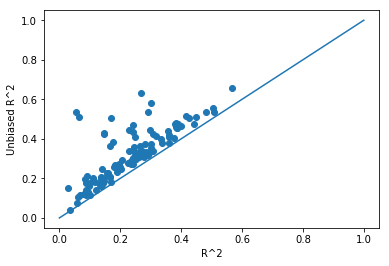

In [10]:
true_rs = np.array(true_rs)
plt.scatter(true_rs[...,1], true_rs[...,0])
plt.xlabel('R^2');plt.ylabel('unbiased R^2')
#plt.scatter(rs[:,1], rs[:,0]);
plt.xlabel('R^2');plt.ylabel('Unbiased R^2');
#plt.xlim(0,1);plt.ylim(0,1);
plt.plot([0,1],[0,1])

In [11]:
orig_apc = [ 0.76009 ,  0.584525,  0.198936,  0.157071,  0.647961,  0.37646 ,
        0.467155,  0.324034,  0.399389,  0.363057,  0.483304,  0.63942 ,
        0.404063,  0.546408,  0.513553,  0.533464,  0.512612,  0.329118,
        0.459758,  0.4788  ,  0.407355,  0.635701,  0.443125,  0.569788,
        0.387988,  0.577394,  0.398621,  0.4995  ,  0.25157 ,  0.239755,
        0.327591,  0.547663,  0.671654,  0.264618,  0.358223,  0.434826,
        0.604545,  0.800249,  0.60166 ,  0.492889,  0.591263,  0.389727,
        0.669667,  0.416541,  0.403288,  0.578402,  0.367616,  0.414538,
        0.5374  ,  0.524445,  0.518847,  0.443877,  0.398648,  0.443079,
        0.458442,  0.308677,  0.632796,  0.607198,  0.575252,  0.456918,
        0.550541,  0.64086 ,  0.653112,  0.564139,  0.351454,  0.350359,
        0.369773,  0.474352,  0.521086,  0.507087,  0.593444,  0.68297 ,
        0.403103,  0.376936,  0.413483,  0.395759,  0.61047 ,  0.506955,
        0.562467,  0.30806 ,  0.278872,  0.44489 ,  0.592218,  0.280477,
        0.511627,  0.32738 ,  0.579836,  0.278382,  0.451602,  0.441718,
        0.775519,  0.514955,  0.414231,  0.345469,  0.57362 ,  0.282116,
        0.317084,  0.482141,  0.507757,  0.584739,  0.456035,  0.419963,
        0.483695,  0.2925  ,  0.569279,  0.557298,  0.541201,  0.70165 ,
        0.714507]

In [12]:
#fit apc model
fn = '/loc6tb/data/models/apc_models_362.nc'
apc = xr.open_dataset(fn)['resp']
apc['models'] = range(apc.shape[1])
apc

fn = 'bvlc_reference_caffenetpix_width[ 8.4096606]_x_(64, 164, 51)_y_(114.0, 114.0, 1)PC370'

da = xr.open_dataset('/loc6tb/data/responses/v4cnn/' + fn + '.nc')['resp']
da = da.sel(unit=slice(0, None, 1)).squeeze()
middle = np.round(len(da.coords['x'])/2.).astype(int)
da_0 = da.sel(x=da.coords['x'][middle])

da_0 = da_0.loc[apc.coords['shapes'].values]
da_0 = da_0 - da_0.mean('shapes')
da_0n = da_0/(da_0.dot(da_0, 'shapes'))**0.5
print('')
print(da_0n)
print(apc)



<xarray.DataArray 'resp' (shapes: 362, unit: 22096)>
array([[-0.086207, -0.049772,  0.045202, ...,  0.008466, -0.008261, -0.045501],
       [ 0.015098, -0.000742, -0.033846, ..., -0.066344, -0.089565,  0.036247],
       [ 0.071429, -0.070447,  0.118781, ..., -0.046032, -0.017727, -0.049792],
       ..., 
       [ 0.015098, -0.000742, -0.033846, ..., -0.030087, -0.024063,  0.037703],
       [ 0.015098, -0.000742, -0.033846, ...,  0.046108,  0.03367 ,  0.028236],
       [ 0.02881 ,  0.008895, -0.016498, ...,  0.003474, -0.003735,  0.057476]], dtype=float32)
Coordinates:
    layer_label  (unit) |S5 'conv1' 'conv1' 'conv1' 'conv1' 'conv1' 'conv1' ...
  * unit         (unit) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    layer        (unit) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    layer_unit   (unit) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * shapes       (shapes) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 18 19 20 21 ...
    x            float

In [32]:
r = da_0n.chunk({'unit':1000}).dot(apc.chunk({'models':1000}), 'shapes')
rbest = r.max('models')

/home/dean/anaconda2/lib/python2.7/site-packages/dask/array/core.py:2070: UserWarning: Increasing number of chunks by factor of 23
  (nparts / max_parts))


In [ ]:
r = r.load()

In [36]:
r.coords['cur_mean']

<xarray.DataArray 'cur_mean' (models: 65536)>
array([-0.5, -0.4, -0.3, ...,  0.8,  0.9,  1. ])
Coordinates:
    x         float64 116.0
    scale     float64 8.41
    y         float64 114.0
    or_sd     (models) float64 0.4014 0.4014 0.4014 0.4014 0.4014 0.4014 ...
    or_mean   (models) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    cur_sd    (models) float64 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 ...
    cur_mean  (models) float64 -0.5 -0.4 -0.3 -0.2 -0.1 0.0 0.1 0.2 0.3 0.4 ...
  * models    (models) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...

In [29]:
ind = r.argmax(1)

In [31]:
r


array([[ 0.12286032,  0.12522547,  0.12557687, ..., -0.06995073,
        -0.12352242, -0.15976883],
       [ 0.0157561 ,  0.01634168,  0.01675728, ...,  0.17490493,
         0.18856414,  0.18902519],
       [-0.21506748, -0.20905977, -0.18239349, ..., -0.36898618,
        -0.30598292, -0.23202315],
       ..., 
       [ 0.12388295,  0.12097582,  0.10551402, ..., -0.10393684,
        -0.14367432, -0.16746402],
       [-0.16072578, -0.15823485, -0.11599856, ...,  0.12429768,
         0.18398176,  0.22321211],
       [ 0.46600359,  0.45715721,  0.40375739, ...,  0.01793961,
        -0.10067789, -0.19172202]])

()


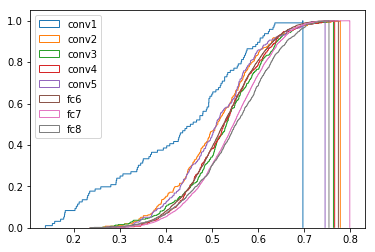

In [14]:
#plt.plot(rbest)
layers = np.unique(da_0n.coords['layer_label'].values)[:8]
print()
for layer in layers:
    layer_rs = rbest[da_0n.coords['layer_label'].values==layer].squeeze()
    layer_rs = layer_rs[~np.isnan(layer_rs)]
    plt.hist(layer_rs, cumulative=True, normed=True, histtype='step',bins=1000);
plt.legend(layers)

()


(0.1, 0.8)

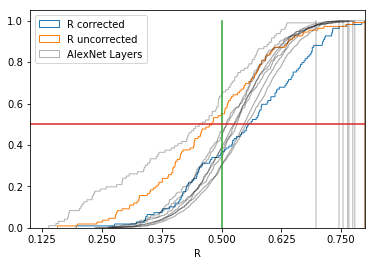

In [17]:
#true_rs[true_rs<0] = 0
#true_rs[true_rs>1] = 1
#plt.hist(true_rs[...,1]**0.5, cumulative=True, normed=True,bins=1000, histtype='step');
plt.hist(true_rs[...,0]**0.5, cumulative=True, normed=True,bins=1000, histtype='step');
plt.hist(orig_apc, cumulative=True, normed=True,bins=1000, histtype='step')
#plt.hist(rbest[~np.isnan(rbest)], cumulative=True, normed=True, histtype='step',bins=1000);
plt.xlim(0,1)
plt.xlabel('R')
plt.xticks(np.round(np.linspace(0,1,9),3))

layers = np.unique(da_0n.coords['layer_label'].values)[:8]
print()

for layer in layers:
    layer_rs = rbest[da_0n.coords['layer_label'].values==layer].squeeze()
    layer_rs = layer_rs[~np.isnan(layer_rs)]
    plt.hist(layer_rs, cumulative=True, normed=True, histtype='step',bins=1000, alpha=0.3, color='k');
    
plt.legend(['R corrected', 'R uncorrected', 'AlexNet Layers'],loc='upper left')
plt.plot([0.5,0.5], [0,1]);plt.plot([0,1],[.5,.5])
#plt.hist(true_rs[~np.isnan(true_rs[...,0]),0]**0.5, cumulative=True, normed=True, histtype='step')
plt.xlim([0.1,.8])

/home/dean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


56

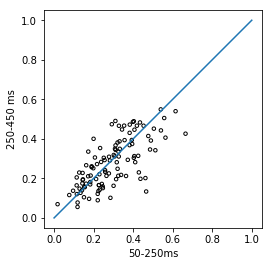

ValueError: Only 2d plots are supported for facets in xarray. See the package `Seaborn` for more options.

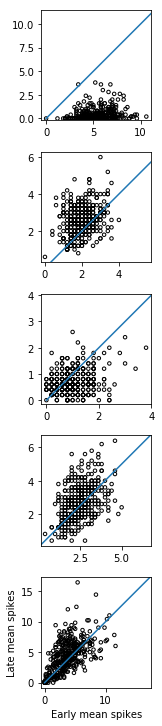

In [768]:
diffs = (np.argsort(time_r[0]-time_r[1]))[::-1]

r = (v4[diffs[:5], :, :5].groupby_bins('t', bins=[50,250,600], labels=[50, 250]
                                  ).sum('t')).mean('trial')
plt.figure(figsize=(2,10))
for i, unit in enumerate(r):
    plt.subplot(5,1,i+1)
    plt.scatter(unit[:,0], unit[:,1],s=12, edgecolors='k', facecolors='none')
    plt.xlim([unit.min()*.9,unit.max()*1.1]);plt.ylim([unit.min()*.9,unit.max()*1.1]);
    plt.axis('square')
    plt.plot([0, unit.max()*1.1], [0, unit.max()*1.1])
plt.tight_layout()
plt.xlabel('Early mean spikes');plt.ylabel('Late mean spikes')


## The distribution of $R^2$  ##

$R^2$ is just $\frac{Explained \ variance}{Total  \ variance} $ lets examine the numerator and denominator seperately.

### Explained  variance ###

Well the model of our responses is:
$$ \vec{Y} = \mu + \beta \vec{x} + \alpha \vec{e} + \vec{\epsilon} $$

$$\epsilon_i \sim N(0,\frac{1}{n})$$
$\alpha \vec{e}$ is the residual of our true means and model.

Explained variance is just the squared length of our fit of $\vec{x}$ to $\vec{Y}$ : $|\hat{\beta}\vec{x}|^2$

where $\hat{\beta}$ is the signed length of the projection of $\vec{x}$ on $\vec{Y}$ which has a normal distribution (it is just a linear transformation of a normal so is normal):
$$\hat{\beta} = \frac{\vec{Y} \cdot \vec{x}}{|\vec{x}|^2} = \vec{Y} \cdot \vec{x} \sim N(\beta, \frac{1}{n})$$
so the squared length is then a scaled non-central chi-squared random variable with m degrees of freedom because it is a sum of m squared normals:
$$|\hat{\beta}\vec{x}|^2 \sim \frac{1}{n} \chi^2_m(n\beta^2) $$ keeping in mind that $\beta^2 = \sum_i^m{(f({\lambda_i}) - \overline{{f({\lambda}})})^2}$. 

### Total variance ###

$\chi^2_1(n\beta^2) +  \chi^2_{m-2}(n\alpha^2)$

### Putting this all together ###

$$ R^2 \sim \frac{\frac{1}{n} \chi^2_1(n\beta^2)}{\frac{1}{n} \chi^2_1(n\beta^2) +  \frac{1}{n} \chi^2_{m-2}(n\alpha^2)} = \frac{ \chi^2_1(n\beta^2)}{ \chi^2_1(n\beta^2) +  \chi^2_{m-2}(n\alpha^2)} $$

Since for a non-central chi-squared random variable: $E[\chi^2_m(a)] = a + m$

$$Numerator \ \ E[\frac{1}{n} \chi^2_1(n\beta^2)] = \frac{1}{n} E[\chi^2_1(n\beta^2)] = \frac{1}{n}(1 + n\beta^2) = \beta^2 + \frac{1}{n} $$

$$Denominator \ \ E[\frac{1}{n} \chi^2_{m-2}(n\alpha^2) + \frac{1}{n} \chi^2_{1}(n\beta^2)] = \alpha^2 + \frac{1}{n}(m-2) + \beta^2 + \frac{1}{n}$$


while this is a bit of a hack we will just subtract of the right amount from the numerator and denominator to make them approximately unbiased:

Numerator correction $= - \frac{1}{n}$

Denominator correction $=- \frac{1}{n}(m-2) - \frac{1}{n}$

So lets give it a try:

In [490]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.nonparametric.kernel_regression as kr

def transform(x, a, b):
    y = ((np.sqrt(a)*(1-0.5*b))**-1)*x**((1-0.5*b))
    return y

def r2_unbiased(y, x):
    (n, m) = np.shape(y)
    y = y.mean(0)
    y -= y.mean()
    x -= x.mean()
    b = np.dot(y, x)/np.dot(x, x)
    y_hat = b*x#our best fit of x to y in the 1-d model space
    res = y-b*x#the left over residual in (m-2)-d null space
    num = np.sum(y_hat**2)
    den = np.sum(y_hat**2) + np.sum(res**2)
    
    R2 = (num)/(den)    
    R2_corrected = (num - (1./n))/((den - (m-2)*(1./n) - (1./n)))
    R2_corrected = (num - (1./n))/((den - (m-1)*(1./n)))
    return R2_corrected, R2

def kernel_reg_v_pred(y):
    y_bar = y.mean(0)
    y_var = y.var(0)
    
    v_pred = kr.KernelReg((y_var), (y_bar), 'c', reg_type='lc', bw='aic').fit(y_bar)[0];
    return v_pred
      
def log_lin_vpred(y):
    y_bar = y.mean(0)
    y_var = y.var(0)
    
    ml = np.log10(y_bar)
    vl = np.log10(y_var)
    intercept= np.ones(len(ml))
    A = np.vstack([ml, intercept]).T
    b_est, c = np.linalg.lstsq(A, vl)[0]
    b = b_est
    a = 10.**c
    
    return (a,b)

def r2_unbiased_vmr(y, x, ab):
    (a,b) = ab
    (n, m) = np.shape(y)
    y = transform(y, a, b)
    y = y.mean(0)
    
    y -= y.mean()
    x -= x.mean()
    b = np.dot(y, x)/np.dot(x, x)
    y_hat = b*x#our best fit of x to y in the 1-d model space
    res = y-b*x#the left over residual in (m-2)-d null space
    num = np.sum(y_hat**2)
    den = np.sum(y_hat**2) + np.sum(res**2)
    
    R2 = (num)/(den)    
    R2_corrected = (num - (1./n))/((den - (m-2)*(1./n) - (1./n)))
    R2_corrected = (num - (1./n))/((den - (m-1)*(1./n)))
    return R2_corrected, R2

n = 5 #trials
m = 362 #stimuli
n_exps = 100 #number simulations
amplitude = 5.
base_line = 10
true_r2 = 0.5
angle = np.arccos(true_r2**0.5)

a = 1
b = 1

#create the expected responses
lambdas = base_line + (np.cos(np.linspace(0, 2*np.pi, m))*amplitude) #s
#our model is not perfect, thus its angle is some angle off
model = base_line+(np.cos(angle + np.linspace(0, 2*np.pi, m))*amplitude) #s
a=1
b=1

y = np.random.normal(lambdas, a*lambdas**b, size=(n_exps, n, m)) # n_experiments n_trials m_stimuli
y = np.random.poisson(lambdas, size=(n_exps, n, m)) # n_experiments n_trials m_stimuli
y = np.random.negative_binomial(lambdas, 0.1, size=(n_exps, n, m))
y_bar = y.mean(1)
y_var = np.var(y, 1)
inds = (y_var>0)*(y_bar>0)
print(np.shape(inds))
#r2_vmr = np.array([r2_unbiased_vmr(exp, model, n, m) for exp in y])
r2_logfit = np.array([r2_unbiased_vmr(exp[:,ind], model[ind], log_lin_vpred(exp[:,ind])) for exp, ind in zip(y, inds)])
r2_logfit = np.array([r2_unbiased_vmr(exp[:,ind], model[ind], (vmr(exp[:,ind]),1)) for exp, ind in zip(y, inds)])

#r2_logfit = np.array([r2_unbiased_vmr(exp[:,ind], model[ind], exp[:,ind].mean(0)) for exp, ind in zip(y, inds)])

y = 2*np.sqrt(y)
r2_per_trans= np.array([r2_unbiased(exp[:,ind], model[ind]) for exp, ind in zip(y, inds)])

(100, 362)


/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:41: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


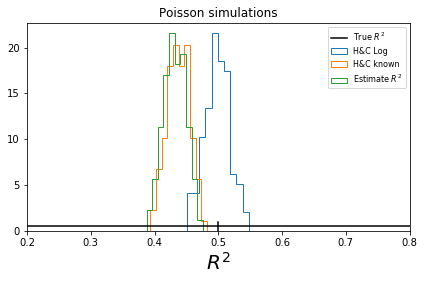

In [493]:
#import seaborn as sns
#sns.reset_defaults()
plt.hist(r2_logfit[..., 0], normed=True,  histtype='step', bins=10)
#plt.hist(r2_vmr[..., 0], normed=True,  bins=10, histtype='step',cumulative=True)
plt.hist(r2_per_trans[..., 0], normed=True,  bins=10, histtype='step')
plt.hist(r2_per_trans[..., 1], normed=True,  bins=10, histtype='step')


actual_r = np.corrcoef(np.sqrt(model), np.sqrt(lambdas))[0,1]**2
plt.plot([true_r2, true_r2], [0,1], c='k')
plt.xlim([0.2, .8])
plt.legend([ r'True $R^2$', r'H&C Log', r'H&C known', r'Estimate $R^2$', ], loc='upper right', fontsize=8)
plt.xlabel(r'$R^2$', fontsize=20)
plt.title('Poisson simulations')
plt.plot([0, 1], [.5,.5], c='k')

plt.tight_layout()

/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:41: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in log10


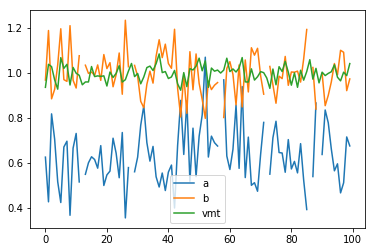

In [438]:
y = np.random.poisson(lambdas, size=(n_exps, n, m)) # n_experiments n_trials m_stimuli

def vmr(y):
    y_var = np.var(y,0,ddof=1)
    y_bar = np.mean(y,0)
    rat = ((y_var)/(y_bar)).mean()
    return rat

plt.plot([log_lin_vpred(exp[:,ind]) for exp, ind in zip(y, inds)])
plt.plot([vmr(exp) for exp, ind in zip(y, inds)])
plt.legend(['a','b','vmt'])

/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[1.         0.94918032]
 [0.94918032 1.        ]]


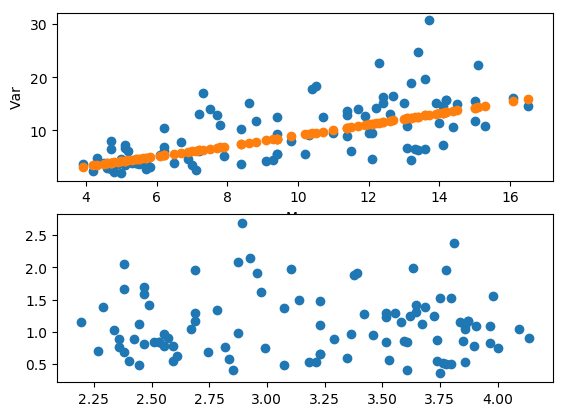

In [353]:
n = 10 #trials
m = 100 #stimuli
n_exps = 1000 #number simulations
lambdas = lambdas.astype(int)
p=1./lambdas

true_mu = (lambdas*(1-p))/(p)
true_var = ((1-p)*lambdas)/(p**2)

y = np.random.negative_binomial(lambdas, p, size=(n_exps, n, m))[0]
y = np.random.poisson(lambdas, size=(n_exps, n, m))[0]

y_bar = y.mean(0)
y_var = np.var(y, 0, ddof=1)

ind = np.array((y_bar>0)*(y_var>0)).squeeze()
y = y[...,ind]

y_var = y_var[ind]
y_bar = y_bar[ind]


#v_pred = st.nonparametric.kernel_regression.KernelReg((y_var), 
#                                                      (y_bar), 
#                                                      'c', 
#                                                      reg_type='lc').fit(y_bar);


v_pred = v_pred[0]

ml = np.log10(y_bar)
vl = np.log10(y_var)
intercept= np.ones(len(ml))
A = np.vstack([ml, intercept]).T
b_est, c = np.linalg.lstsq(A, vl)[0]
b = b_est
a = 10.**c

v_pred = a*y_bar**b

y_new = y/(v_pred**0.5)

plt.subplot(211)
plt.scatter(y_bar, y_var)
plt.scatter(y_bar, v_pred)
plt.xlabel('Mean')
plt.ylabel('Var')
#plt.loglog()

#plt.scatter(true_mu, true_var, color='r')

plt.subplot(212)

y_bar = y_new.mean(0)
y_var = np.var(y_new, 0,ddof=1)
plt.scatter(y_bar, y_var)

#plt.loglog()

print(np.corrcoef(true_mu, y_bar))

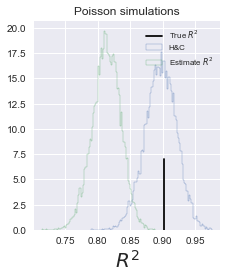

In [104]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def r2_unbiased(y, x, n, m):
    y -= y.mean()
    x -= x.mean()
    b = np.dot(y, x)/np.dot(x, x)
    y_hat = b*x#our best fit of x to y in the 1-d model space
    res = y-b*x#the left over residual in (m-2)-d null space
    num = np.sum(y_hat**2)
    den = np.sum(y_hat**2) + np.sum(res**2)
    
    R2 = (num)/(den)    
    R2_corrected = (num - (1./n))/((den - (m-2)*(1./n) - (1./n)))

    return R2_corrected, R2

n = 4 #trials
m = 40 #stimuli
n_exps = 5000 #number simulations
amplitude = 3
base_line = 4
true_r2 = 0.5
angle = np.arccos(true_r2**0.5)

a = 1
b = 1

#create the expected responses
lambdas = base_line + (np.cos(np.linspace(0, 2*np.pi, m))*amplitude) #s
#our model is not perfect, thus its angle is some angle off
model = base_line+(np.cos(angle + np.linspace(0, 2*np.pi, m))*amplitude) #s

y = np.random.normal(lambdas, (a*lambdas**b)**0.5, size=(n_exps, n, m)) # n_experiments n_trials m_stimuli
y = np.abs(y)
y_bar = y.mean(1,) # average the trials
y_var = y.var(1, ddof=1,)

#fit vmr
intercept = np.ones(m)
'''
print(intercept.shape)
print(y_bar.shape)
vmr_fit = []
for i in range(n_exps):
    mt = np.log(y_bar[i])
    vt = np.log10(y_var[i])
    A = np.vstack([mt, intercept]).T
    b_est, c = np.linalg.lstsq(A, vt)[0]
    a_est = 10.**c 
    vmr_fit.append([a_est, b_est])
vmr_fit = np.array(vmr_fit)  
    
'''
def transform(x, a, b):
    y = ((np.sqrt(a)*(1-0.5*b))**-1)*x**((1-0.5*b))
    return y

#get the fraction of variance
#r2 = np.array([r2_unbiased(transform(exp, the_a, the_b), transform(model, the_a, the_b), n, m) 
#               for exp, the_a, the_b in zip(y_bar.squeeze(), vmr_fit[:,0], vmr_fit[:,1])])

#r2 = np.array([r2_unbiased(transform(exp, 1, 1), transform(model, 1, 1), n, m) 
#               for exp, the_a, the_b in zip(y_bar.squeeze(), vmr_fit[:,0], vmr_fit[:,1])])



r2 = np.array([r2_unbiased(np.sqrt(exp), np.sqrt(model), n, m) for exp in y_bar])

/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


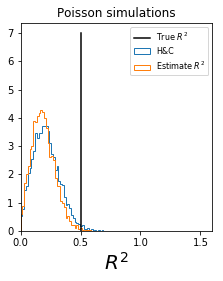

In [107]:
plt.subplot(122)
#plt.plot(np.sqrt(model))
#plt.plot(np.sqrt(lambdas))
#plt.xlabel('Stimuli');plt.ylabel('sqrt(spk/s)')
#plt.tight_layout()

plt.hist(r2[..., 0], normed=True, range=(0,1.5), histtype='step', bins=100)
plt.hist(r2[..., 1], normed=True, range=(0,1.5), bins=100, histtype='step',)


actual_r = np.corrcoef(np.sqrt(model), np.sqrt(lambdas))[0,1]**2
plt.plot([actual_r, actual_r], [0,7], c='k')
plt.xlim([0, 1.6])
plt.legend([ r'True $R^2$', r'H&C', r'Estimate $R^2$', ], loc='upper right', fontsize=8)
plt.xlabel(r'$R^2$', fontsize=20)
plt.title('Poisson simulations')
plt.tight_layout()

$$\frac{\hat{\beta^2} +\frac{1}{n}}{\frac{1}{n} \hat{\alpha^2} + \frac{1}{n}(m-2) + \hat{\beta^2} + \frac{1}{n}} $$

Where \hat{beta^2} is the squared length of our model response on our transformed neural response, \hat{alpha^2} is the squared length of the residual, n is number of trials and m is number of stimuli.

Our transformation is:

$$f(x) = (\sqrt{\hat{a}}(1-\frac{1}{2}b))^{-1}x^{1-\frac{1}{2}b}$$

We assume $b=1$ and estimate $a$ via:

$\hat{a} = \sum_i^m{\frac{s^2_i}{\bar{x}_i}}$